In [1]:
%matplotlib inline
import math
import numpy as np
from numpy import *
from scipy.optimize import curve_fit
from scipy import signal
from os import path
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Input, Dense, GRU, Embedding, Dense, Activation, Dropout, LSTM
from keras.optimizers import Adam
from keras import optimizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau


Using TensorFlow backend.


In [2]:
plt.rc('text', usetex=True)

outpath = "../../../plots/temperatures"
inpath = "../../../"

currentfile = "Imitator_2_2400.csv"

# Read from file
strdatatype = np.dtype([('N', np.int_, (2,)), ('Time_Count', np.int_ ), ('Mode', np.int_ ),
                        ('T', np.float_, (10,)), ('S', np.bool_, (10,)), ('System_State', np.bool_ )])
N, Time_Count, Mode, T, S, System_State = np.loadtxt(path.join(inpath, currentfile), 
                                                     unpack=True, delimiter=';', skiprows=1, dtype=strdatatype)

In [3]:
max_possible_model_temperature = 18
min_possible_model_temperature = 66
def scale_T(_T):
    return ((_T - min_possible_model_temperature) / (max_possible_model_temperature - min_possible_model_temperature)) * 2.0 - 1.0

def unscale_T(_T):
    return ((_T + 1.0) / 2.0) * (max_possible_model_temperature - min_possible_model_temperature) + min_possible_model_temperature

In [4]:
outputBlockId=0

In [5]:
sT = scale_T(T)

In [6]:
print(np.amax(T), np.amin(T))
print(np.amax(sT), np.amin(sT))

65.14203288058243 18.40911018644466
0.9829537422314722 -0.9642513700242681


In [7]:
delta = np.amin(np.abs(sT[:-2, :] - sT[1:-1, :])) 

In [8]:
delta

4.885262602116747e-06

In [9]:
#data augmintation -- 50000 slightly tuned copies of T
agmntCount=5000
agmntdT=np.zeros((agmntCount, np.size(sT[:,0]), np.size(sT[0,:])))
agmntdT[0,:,:] = sT
np.random.seed(0)
mu, sigma = 0, delta*1000
for i in range(1, agmntCount):
    agmntdT[i] = agmntdT[0] + np.random.normal(mu, sigma, (np.size(sT[:,0]), np.size(sT[0,:])))

In [10]:
agmntdT.shape

(5000, 2401, 10)

In [11]:
predictSteps = 1

In [12]:
#Keep dataset tail for validate prediction quality
cutFromTail = 150
#In order to have shifted and unshifted series with same shape
t = cutFromTail + predictSteps

In [13]:
#inData = np.zeros((agmntCount, np.size(sT[:-t,0]), np.size(sT[0,:]) + 1))
#for i in range(0, agmntCount):
#    inData[i,:,0] = Mode[:-t] / np.amax(Mode[:-t])
#    inData[i,:,1:]= agmntdT[i,:-t,:]

inData = np.zeros((agmntCount, np.size(sT[:-t,0]), np.size(sT[0,:])))
for i in range(0, agmntCount):
    inData[i,:,:]= agmntdT[i,:-t,:]

In [14]:
inData.shape

(5000, 2250, 10)

In [15]:
outData = np.expand_dims(agmntdT[:,predictSteps:-cutFromTail,outputBlockId], axis=2) 

In [16]:
outData.shape

(5000, 2250, 1)

In [17]:
num_data = len(inData[0,:,0])
num_data

2250

In [18]:
train_split = 0.83

In [19]:
num_train = int(train_split * num_data)
num_train

1867

In [20]:
num_test = num_data - num_train
num_test

383

In [21]:
inData_train = inData[:, 0:num_train, :]
inData_test = inData[:, num_train:, :]
len(inData_train[0,:,0]) + len(inData_test[0,:,0])

2250

In [22]:
outData_train = outData[:, 0:num_train, :]
outData_test = outData[:, num_train:, :]
len(outData_train[0,:,0]) + len(outData_test[0,:,0])

2250

In [23]:
num_inData_signals = inData.shape[2]
num_inData_signals

10

In [24]:
num_outData_signals = outData.shape[2]
num_outData_signals

1

In [25]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15054327208346555318
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3387752448
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6587557580029732870
physical_device_desc: "device: 0, name: GeForce GTX 770, pci bus id: 0000:01:00.0, compute capability: 3.0"
]


In [26]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """
    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        in_shape = (batch_size, sequence_length, num_inData_signals)
        in_batch = np.zeros(shape=in_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        out_shape = (batch_size, sequence_length, num_outData_signals)
        out_batch = np.zeros(shape=out_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            # This points somewhere into the augmented series range.
            idaugmnt = np.random.randint(agmntCount)
            
            # Copy the sequences of data starting at this index.
            in_batch[i] = inData_train[idaugmnt, idx:idx+sequence_length,:]
            out_batch[i] = outData_train[idaugmnt, idx:idx+sequence_length,:]
        
        yield (in_batch, out_batch)

In [27]:
batch_size = 500

In [28]:
#sequence_length=576
sequence_length=120

In [29]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

In [30]:
in_batch, out_batch = next(generator)

In [31]:
print(in_batch.shape)
print(out_batch.shape)

(500, 120, 10)
(500, 120, 1)


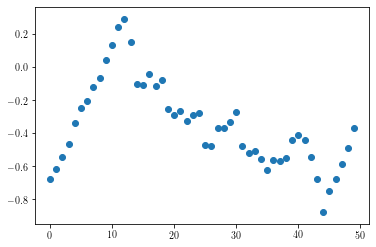

In [32]:
batch = 0   # First sequence in the batch.
seq = in_batch[batch,predictSteps:predictSteps+50, outputBlockId]
plt.scatter(np.arange(0, len(seq)), seq)

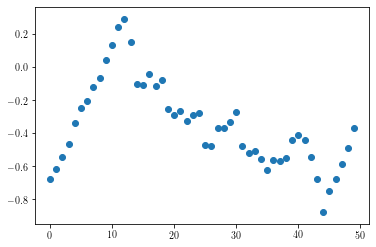

In [33]:
seq = out_batch[batch, 0:50, 0]
plt.scatter(np.arange(0, len(seq)),seq)

In [34]:
validation_data = (np.expand_dims(inData_test[0,:,:], axis=0),
                   np.expand_dims(outData_test[0,:,:], axis=0))

In [35]:
model = Sequential()

In [36]:
model.add(LSTM(512, return_sequences=True, input_shape=(None, num_inData_signals,)))
model.add(LSTM(5, return_sequences=True))
model.add(Dense(1, activation = "linear"))

In [37]:
warmup_steps = 10
import keras.backend as K
def loss_mse_warmup(y_true, y_pred): 
    return K.mean(K.square(y_pred[:, warmup_steps:, :]-y_true[:, warmup_steps:, :]))

In [38]:
#model.compile(Adam(learning_rate=1e-4), loss='mean_absolute_error')
model.compile(Adam(learning_rate=5e-5), loss=loss_mse_warmup)

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 512)         1071104   
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 5)           10360     
_________________________________________________________________
dense_1 (Dense)              (None, None, 1)           6         
Total params: 1,081,470
Trainable params: 1,081,470
Non-trainable params: 0
_________________________________________________________________


In [40]:
path_checkpoint = str(outputBlockId)+'_multistep_test.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [41]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [42]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-9,
                                       patience=0,
                                       verbose=1)

In [43]:
callbacks = [callback_early_stopping,
            callback_checkpoint,
            callback_reduce_lr]

In [44]:
#try:
#    model.load_weights("0_multistep_test.keras")
#except Exception as error:
#    print("Error trying to load checkpoint.")
#    print(error)

In [45]:
%%time
model.fit_generator(generator=generator,
                    epochs=100000,
                    steps_per_epoch=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/100000
10/10 [==============================] - 6s 636ms/step - loss: 0.1168 - val_loss: 0.1209

Epoch 00001: val_loss improved from inf to 0.12089, saving model to 9_multistep_test.keras
Epoch 2/100000
10/10 [==============================] - 6s 561ms/step - loss: 0.0932 - val_loss: 0.1112

Epoch 00002: val_loss improved from 0.12089 to 0.11122, saving model to 9_multistep_test.keras
Epoch 3/100000
10/10 [==============================] - 6s 564ms/step - loss: 0.0836 - val_loss: 0.0918

Epoch 00003: val_loss improved from 0.11122 to 0.09179, saving model to 9_multistep_test.keras
Epoch 4/100000
10/10 [==============================] - 6s 556ms/step - loss: 0.0749 - val_loss: 0.0796

Epoch 00004: val_loss improved from 0.09179 to 0.07963, saving model to 9_multistep_test.keras
Epoch 5/100000
10/10 [==============================] - 6s 559ms/step - loss: 0.0676 - val_loss: 0.0713

Epoch 00005: val_loss improved from 0.07963 to 0.07126, saving model to 9_multistep_test.keras
Epoc

In [46]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [47]:
result = model.evaluate(x=np.expand_dims(inData_test[0], axis=0),
                        y=np.expand_dims(outData_test[0], axis=0))

1/1 [==============================] - 0s 79ms/step


In [48]:
print("loss (test-set):", result)

loss (test-set): 0.025798434391617775


In [49]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = inData_train[0]
        y_true = outData_train[0]
    else:
        # Use test-data.
        x = inData_test[0]
        y_true = outData_test[0]
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    print(shape(x))
    print(shape(y_pred))
        
    # Get the output-signal predicted by the model.
    signal_pred = y_pred
        
    # Get the true output-signal from the data-set.
    signal_true = y_true
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))
        
    # Plot and compare the two signals.
    plt.plot(signal_true, label='true')
    plt.scatter(np.arange(0, len(signal_pred[0])), signal_pred[0,:,:], label='pred', color='r')

        
    # Plot labels etc.
    plt.legend()
    plt.show()

(1, 383, 10)
(1, 383, 1)


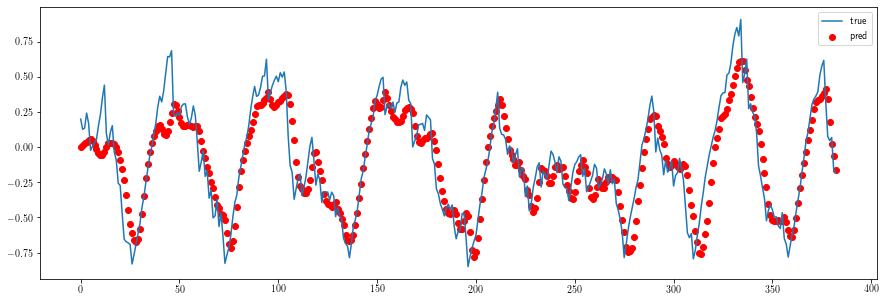

In [50]:
plot_comparison(start_idx=0, length=400, train=False)


In [51]:
sequence_length_for_predict = sequence_length

def predStepForAllBlc(_in):
    _out = np.zeros((1, sequence_length_for_predict, 10))
    for blk_id in range(0, 10):
            path_to_current_model = str(blk_id)+'_multistep_test.keras'
            try:
                model.load_weights(path_to_current_model)
            except Exception as error:
                print("Error trying to load model for block "+str(blk_id+1))
                print(error)
            _out[0, :, blk_id] = model.predict(_in)[0,:,0]
    return _out[0, -predictSteps:, :]
            
def performOfSamplePrediction(outOfSampleCount):    
    prediction = np.zeros(((outOfSampleCount // predictSteps) * (predictSteps + 1), 10))
    
    predictBase = np.zeros((1, sequence_length_for_predict, num_inData_signals))
    onStepPredict = np.zeros((1, sequence_length_for_predict, 10))
   
    predictBase[0,:,:] = sT[-(sequence_length_for_predict + cutFromTail): -cutFromTail,:]
    
    prediction[0:predictSteps,:] = predStepForAllBlc(predictBase)
    for step in range(predictSteps,outOfSampleCount,predictSteps):
            predictBase[0,:-predictSteps,:] = predictBase[0,predictSteps:,:]
            predictBase[0,-predictSteps:,:] = prediction[(step - predictSteps):step,:]
            prediction[step:step+predictSteps,:] = predStepForAllBlc(predictBase)
    return prediction
           
        

In [52]:
pred = performOfSamplePrediction(predictSteps + cutFromTail)

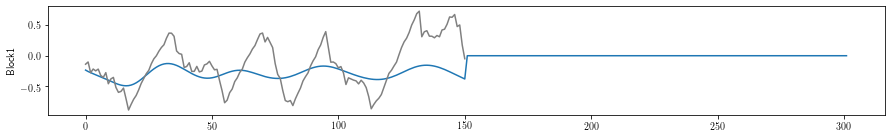

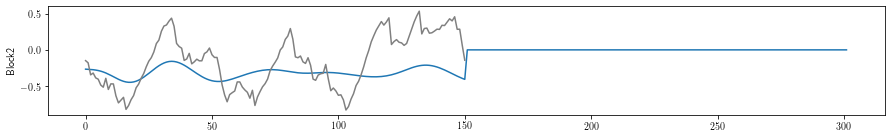

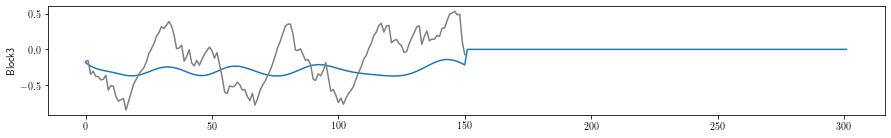

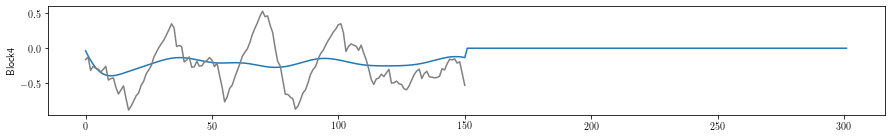

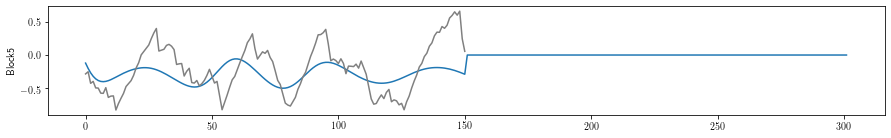

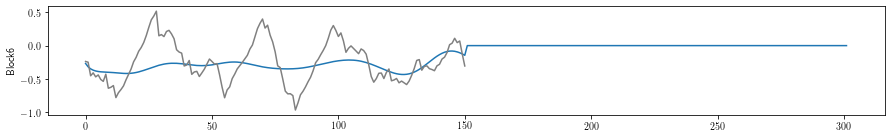

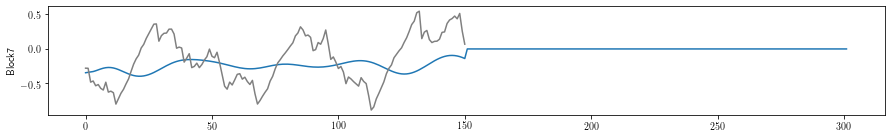

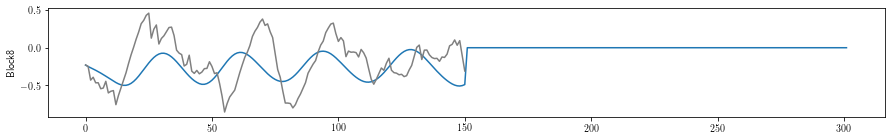

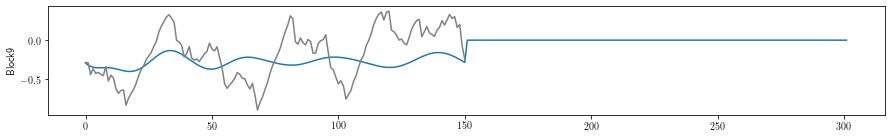

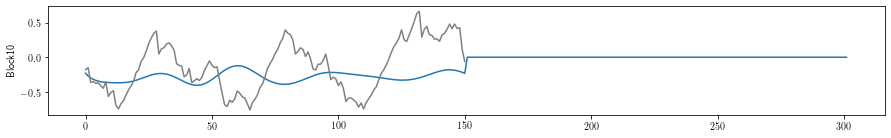

In [53]:
for _id in range (0, 10):
    plt.figure(figsize=(15,2))
    plt.plot(pred[:,_id])
    plt.plot(sT[-(predictSteps + cutFromTail):, _id], color='gray')
    plt.ylabel("Block"+str(_id+1))